In [1]:
import numpy as np
from matplotlib import pyplot as plt

import pandas as pd

import random
import os
import cv2
from sklearn.metrics import roc_curve, auc


import sys
sys.path.append('../scripts')
from utils import *

In [2]:
def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1)

In [3]:
def get_curves(face_ids, n_out: int, trials: list = [0], pca_type: str = 'pca_all', base_dir: str = 'results_all'):
    fprs = []
    tprs = []
    for trial in trials:
        f_count = 0
        for face_id in face_ids:
            labels = np.load(f'./{base_dir}/labels/lbl_{n_out}_t{trial}.npy')
            pca_preds = np.load(f'./{base_dir}/{pca_type}/preds_{face_id}_{n_out}_t{trial}.npy')
            if f_count > 0:
                pca_preds_all += pca_preds
            else:
                pca_preds_all = pca_preds
            f_count += 1
        pca_preds_all = pca_preds_all/np.max(pca_preds_all)
        # Compute ROC curve and AUC

        fpr, tpr, _ = roc_curve(labels, pca_preds_all, drop_intermediate=False)
        fprs.append(fpr)
        tprs.append(tpr)

    fpr = tolerant_mean(fprs)
    tpr = tolerant_mean(tprs)

    return fpr, tpr

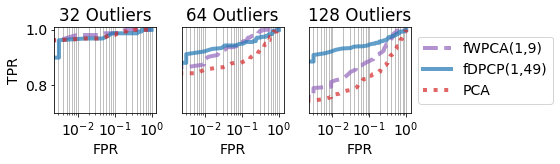

In [31]:
trials = [0,1,2,3,4]

plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(1,3, figsize = (8,2.5))


linestyles = ['solid', '--', 'dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1)), (0, (5, 2)), (0, (3, 1, 1, 1, 1, 1)), (0, (5, 2, 1, 2)), (0, (3, 1, 1, 1, 1, 1, 1, 1))]

face_ids = []
for f in list(np.arange(1,13))+list(np.arange(15,39)):
    if f < 10:
        face_ids.append(f'0{f}')
    else:
        face_ids.append(str(f))

ax_num = 0
for n_out in [32,64,128]: #,64,128]:
    ii=0

    for pca_type, pca_label in zip(['wpca'], ['fWPCA(1,9)']):

        fpr, tpr = get_curves(face_ids, n_out, trials, pca_type)
        axs[ax_num].plot(fpr, tpr, alpha = .7, lw = 4, linestyle = 'dashed', label = f'{pca_label}', color = 'tab:purple')# (AUC = {np.round(roc_auc,2)})')
        ii+=1


    for pca_type, pca_label in zip(['dpcp'], ['fDPCP(1,49)']):

        fpr, tpr = get_curves(face_ids, n_out, trials, pca_type)
        axs[ax_num].plot(fpr, tpr, alpha = .7, lw = 4, linestyle = 'solid', label = f'{pca_label}', color = 'tab:blue')# (AUC = {np.round(roc_auc,2)})')
        ii+=1


    fpr, tpr = get_curves(face_ids, n_out, trials, 'pca')
    axs[ax_num].plot(fpr, tpr, alpha = .7, lw = 4, linestyle = 'dotted', label = f'PCA', color = 'tab:red')# (AUC = {np.round(roc_auc,2)})')
    ii+=1


    axs[ax_num].set_xlabel('FPR')
    axs[0].set_ylabel('TPR')
    axs[ax_num].set_title(f'{n_out} Outliers')
    axs[ax_num].set_xscale('log')
    axs[ax_num].grid(True, which="both", axis = 'x')

    
    ax_num +=1



axs[0].set_ylim([.7,1.01])

axs[1].set_ylim([.70, 1.01])
axs[1].set_yticks([])

axs[2].set_ylim([.70, 1.01])
axs[2].set_yticks([])
axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)


plt.tight_layout()
plt.savefig('faces_roc.pdf')
